In [1]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as tr
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
import torchvision.utils as vutils
import itertools

import os
import numpy as np
from tqdm import tqdm
from sklearn.mixture import GaussianMixture

# Model

In [2]:
nc = 1
ndf = 64
ngf = 64

class MyModel(nn.Module):
    def __init__(self,latent_dim,nClusters):
        super(MyModel,self).__init__()
        
        self.latent_dim = latent_dim
        self.nClusters = nClusters
        self.pi_=nn.Parameter(torch.FloatTensor(self.nClusters,).fill_(1)/self.nClusters,requires_grad=True)
        self.mu_c=nn.Parameter(torch.FloatTensor(self.nClusters,self.latent_dim).fill_(0),requires_grad=True)
        self.log_var_c=nn.Parameter(torch.FloatTensor(self.nClusters,self.latent_dim).fill_(0),requires_grad=True)
        
        self.encoder = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1024, 4, 1, 0, bias=False),
            # nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Sigmoid()
        )
        
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     1024, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     nc, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf),
            # nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            # nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            # nn.Tanh()
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )

        self.fc1 = nn.Linear(1024, 512)
        self.fc21 = nn.Linear(512, latent_dim)
        self.fc22 = nn.Linear(512, latent_dim)

        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, 1024)

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()
    def encode(self, x):
        conv = self.encoder(x);
        # print("encode conv", conv.size())
        h1 = self.fc1(conv.view(-1, 1024))
        # print("encode h1", h1.size())
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        deconv_input = self.fc4(h3)
        # print("deconv_input", deconv_input.size())
        deconv_input = deconv_input.view(-1,1024,1,1)
        # print("deconv_input", deconv_input.size())
        return self.decoder(deconv_input)

    #def reparameterize(self, mu, logvar):
        #std = torch.nan_to_num(logvar.mul(0.5).exp_(),nan=0)  ## Reparameterize nan??
        #std = logvar.mul(0.5).exp_()
        #eps = Variable(std.data.new(std.size()).normal_())
          # num = np.array([[ 1.096506  ,  0.3686553 , -0.43172026,  1.27677995,  1.26733758,
          #       1.30626082,  0.14179629,  0.58619505, -0.76423112,  2.67965817]], dtype=np.float32)
          # num = np.repeat(num, mu.size()[0], axis=0)
          # eps = Variable(torch.from_numpy(num))
        #return eps.mul(std).add_(mu)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def gaussian_pdf_log(self,x,mu,log_sigma2):
        return -0.5*(torch.sum(np.log(np.pi*2)+log_sigma2+(x-mu).pow(2)/torch.exp(log_sigma2),1))
    
    def gaussian_pdfs_log(self,x,mus,log_sigma2s):
    #def gaussian_pdfs_log(x,mus,log_sigma2s):
        G=[]
        for c in range(self.nClusters):
            G.append(self.gaussian_pdf_log(x,mus[c:c+1,:],log_sigma2s[c:c+1,:]).view(-1,1))
        return torch.cat(G,1)
    
    def forward(self, x):
        # print("x", x.size())
        mu, logvar = self.encode(x)
        #decoded = self.decode(mu)
        z = self.reparameterize(mu,logvar)
        z = torch.nan_to_num(z,nan=0)
        #z = torch.randn_like(mu)*torch.exp(logvar/2)+mu
        decoded = self.decode(z)
        # print("decoded", decoded.size())
        return decoded, mu, logvar
    
    def predict(self,x):
        z_mu, z_sigma2_log = self.encode(x)
        z = torch.randn_like(z_mu) * torch.exp(z_sigma2_log / 2) + z_mu
        z = torch.nan_to_num(z,nan=0)
        pi = self.pi_
        log_sigma2_c = self.log_var_c
        mu_c = self.mu_c
        yita_c = torch.exp(torch.log(pi.unsqueeze(0))+self.gaussian_pdfs_log(z,mu_c,log_sigma2_c))

        yita=yita_c.detach().cpu().numpy()
        #print(yita)
        return np.argmax(yita,axis=1)
        
    def RE(self,recon_x,x):
        return torch.nn.functional.binary_cross_entropy(recon_x.view(-1,784),x.view(-1,784),reduction='sum')
        #return torch.nn.functional.binary_cross_entropy(recon_x.view(-1,784),x.view(-1,784),size_average=False)

    def KLD(self,mu,log_var):
        det=1e-10

        pi=self.pi_
        log_var_c = self.log_var_c
        mu_c = self.mu_c

        z = torch.randn_like(mu) * torch.exp(log_var/2) + mu
        z = torch.nan_to_num(z,nan=0)

        yita_c = torch.exp(torch.log(pi.unsqueeze(0))+self.gaussian_pdfs_log(z,mu_c,log_var_c))+det
        yita_c = yita_c/(yita_c.sum(1).view(-1,1))
        loss = 0.5*torch.mean(torch.sum(yita_c*torch.sum(log_var_c.unsqueeze(0)+
                                                    torch.exp(log_var.unsqueeze(1)-log_var_c.unsqueeze(0))+
                                                    (mu.unsqueeze(1)-mu_c.unsqueeze(0)).pow(2)/torch.exp(log_var_c.unsqueeze(0)),2),1))
        loss -= torch.mean(torch.sum(yita_c*torch.log(pi.unsqueeze(0)/(yita_c)),1))+0.5*torch.mean(torch.sum(1+log_var,1))
        return loss
        #return torch.nan_to_num(loss,nan=0)

    def loss_function(self,recon_x,x,mu,log_var):
        return self.RE(recon_x,x)+self.KLD(mu,log_var)

# Input Parameter

In [3]:
latent_dim = 10
nClusters = 13
batch = 100

In [4]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available else {}

# DataLoader

In [5]:
import h5py

In [6]:
data_list = ['../data/normal_dataset.h5','../data/Anomaly_dataset.h5']

In [7]:
imageList=[]
labelList=[]
for file_path in data_list:
    print('Loading data from ', file_path)
    dataset = h5py.File(file_path,'r',libver='latest',swmr=True)
    FimageList=[]
    FlabelList=[]
    for gName,group in dataset.items():
        for dName,data in group.items():
            if dName == 'images':
                FimageList.append(data)
            elif dName == 'labels':
                FlabelList.append(data)

    if len(FimageList) >= 2:
        #print("More than 2 gropus in File")
        image_concat = []
        for i in range(0,len(FimageList)):
            image_concat.append(FimageList[i][:])
        imageList.append(np.concatenate(image_concat))
        label_concat = []
        for i in range(0,len(FlabelList)):
            label_concat.append(FlabelList[i][:])
        labelList.append(np.concatenate(label_concat))
    else:
        imageList.append(FimageList[0][:])
        labelList.append(FlabelList[0][:])
imageList = np.concatenate(imageList)
labelList = np.concatenate(labelList)
print('input image shape : ',imageList.shape)
print('input label shape : ',labelList.shape)
ds = TensorDataset(torch.tensor(imageList),torch.tensor(labelList))
length = [int(len(ds)*0.7),int(len(ds)*0.2)]
length.append(len(ds)-sum(length))

trnSet,valSet,tstSet=torch.utils.data.random_split(ds,length)

#train Loader
train_loader = DataLoader(trnSet, batch_size=batch, shuffle=True, **kwargs)
#test Loader
test_loader = DataLoader(valSet, batch_size=batch, shuffle=False, **kwargs)

Loading data from  ../data/normal_dataset.h5
Loading data from  ../data/Anomaly_dataset.h5
input image shape :  (72100, 1, 28, 28)
input label shape :  (72100,)


# Initial $\gamma$-training

In [8]:
# Initial gamma-training parameter
gamma = 1e-5
gamma_step = 500

In [9]:
def gamma_training(gamma,steps,dataloader):
    optimizer = optim.Adam(model.parameters(),lr=1e-3)
    print('Starting initial gamma training for ',steps,'steps.')
    for batch_idx, (data,_) in tqdm(enumerate(train_loader)):

        #print(batch_idx+1,'step trained')
        data = Variable(data)
        data = data.cuda()
        
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        
        loss = model.RE(recon_batch,data) + gamma * model.KLD(mu,logvar)
        loss.backward()
        #print(loss.item())
        optimizer.step()
        
        if batch_idx +1 == steps:
            print('Training completed')
            break

In [10]:
net = MyModel(latent_dim=latent_dim,nClusters=nClusters)

In [11]:
model = net.cuda()

In [12]:
model.state_dict()

OrderedDict([('pi_',
              tensor([0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769,
                      0.0769, 0.0769, 0.0769, 0.0769], device='cuda:0')),
             ('mu_c',
              tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                     

In [13]:
gamma_training(gamma=gamma,steps=gamma_step,dataloader=train_loader)

Starting initial gamma training for  500 steps.


499it [00:14, 34.72it/s]


Training completed


In [14]:
model.state_dict()

OrderedDict([('pi_',
              tensor([0.3993, 0.3993, 0.3993, 0.3993, 0.3993, 0.3993, 0.3993, 0.3993, 0.3993,
                      0.3993, 0.3993, 0.3993, 0.3993], device='cuda:0')),
             ('mu_c',
              tensor([[-0.1613,  0.3146,  0.0199, -0.1809,  0.2837,  0.3550,  0.2832,  0.1859,
                       -0.1835, -0.1830],
                      [-0.1613,  0.3146,  0.0199, -0.1809,  0.2837,  0.3550,  0.2832,  0.1859,
                       -0.1835, -0.1830],
                      [-0.1613,  0.3146,  0.0199, -0.1809,  0.2837,  0.3550,  0.2832,  0.1859,
                       -0.1835, -0.1830],
                      [-0.1613,  0.3146,  0.0199, -0.1809,  0.2837,  0.3550,  0.2832,  0.1859,
                       -0.1835, -0.1830],
                      [-0.1613,  0.3146,  0.0199, -0.1809,  0.2837,  0.3550,  0.2832,  0.1859,
                       -0.1835, -0.1830],
                      [-0.1613,  0.3146,  0.0199, -0.1809,  0.2837,  0.3550,  0.2832,  0.1859,
         

# mini-Batch GMM initialization

In [15]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
k=round(len(train_loader)*1)

In [16]:
subset = np.random.randint(len(train_loader),size=k*batch)

In [17]:
train_subset_loader = DataLoader(torch.utils.data.Subset(trnSet,subset))

In [18]:
Z=[]
Y=[]
print('GMM Initializing with ',k*batch, 'MC samples')
with torch.no_grad():
    for batch_idx, (data,y) in tqdm(enumerate(train_subset_loader)):
        data = data.cuda()
        
        mu,logvar = model.encode(data)
        
        #assert nn.functional.mse_loss(mu,logvar)==0
        Z.append(mu)
        Y.append(y)
    Z=torch.cat(Z,0).detach().cpu().numpy()
    Y=torch.cat(Y,0).detach().cpu().numpy()
    
    kmeans = KMeans(n_clusters=nClusters, random_state=0)
    kmeans.fit(Z)
    
    #model.mu_c.data = torch.from_numpy(kmeans.cluster_centers).cuda().float()
    
    gmm = GaussianMixture(n_components=nClusters,covariance_type='diag',max_iter=int(1e+04),means_init = kmeans.cluster_centers_,random_state=100)
    #gmm = GaussianMixture(n_components=nClusters,covariance_type='diag',max_iter=int(1e+04))
    
    pre = gmm.fit_predict(Z)
    
    model.pi_.data = torch.from_numpy(gmm.weights_).cuda().float()
    model.mu_c.data = torch.from_numpy(gmm.means_).cuda().float()
    model.log_var_c.data = torch.log(torch.from_numpy(gmm.covariances_).cuda().float())

GMM Initializing with  50500 MC samples


50500it [00:55, 913.92it/s]


In [19]:
model.state_dict()

OrderedDict([('pi_',
              tensor([0.0420, 0.0931, 0.1284, 0.0837, 0.1686, 0.0852, 0.1255, 0.0147, 0.0415,
                      0.0481, 0.0340, 0.0657, 0.0696], device='cuda:0')),
             ('mu_c',
              tensor([[-3.0559,  5.3688, -0.1940, -2.6953, -1.9223,  9.6096,  0.4536, -5.7252,
                        1.8945,  2.2179],
                      [-4.2204,  8.7850, -2.4608, -3.2616, -1.0358, 14.7910, -0.6204, -8.3272,
                        3.7310,  2.1710],
                      [-3.5533,  6.5786, -1.7851, -2.5836, -0.5490, 11.4877, -0.6521, -6.9168,
                        2.9691,  1.6397],
                      [-2.8548,  3.9414, -1.4089, -1.9090,  0.2377,  7.5970, -1.0908, -5.3992,
                        2.2291,  0.7969],
                      [-3.5423,  7.1139, -0.8751, -2.5526, -1.8858, 11.9656, -0.0238, -6.8925,
                        3.0072,  2.5979],
                      [-3.1468,  5.6367, -1.2088, -2.0806, -0.8819,  9.9010, -0.7607, -6.1751,
         

# Periodic $\beta$ - Annealing

In [20]:
n_iter = len(train_loader)
n_cycle = 5
ratio = 0.5
start = gamma
stop = gamma + 1

L = np.ones(n_iter)
period = n_iter/n_cycle
step = (stop-start)/(period*ratio)

for c in range(n_cycle):
    v, i = start, 0
    while v<= stop and (int(i+c*period)<n_iter):
        L[int(i+c*period)]=v
        v += step
        i += 1

# Inverse Min-Max Transform : Avoid NaN Losses

# Test Training

In [21]:
epochs = 300
batch_size = 100 
optimizer=optim.Adam(model.parameters())
outf = './test'

In [22]:
def train(epoch):
    model.train()
    #print('train')
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        #print(data.shape)
        #print(data)
        if torch.cuda.is_available():
            data = data.cuda()
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        
        beta = L[batch_idx]
        
        #print(recon_batch.shape,mu.shape,logvar.shape)
        #print(recon_batch.view(-1,784))
        #print(recon_batch.shape)
        #print(recon_batch)
        #print(data.shape)
        #print(model.RE(recon_batch,data))
        #print(model.KLD(mu,logvar))
        loss = model.RE(recon_batch,data) + beta * model.KLD(mu,logvar)
        
        #loss = model.loss_function(recon_batch,data,mu,logvar)
        
        if torch.isnan(loss.data.cpu()):
        #if np.isnan(loss.data.item()):
            print('NaN Loss!')
            print('RE : ',model.RE(recon_batch,data)/len(recon_batch))
            print('KL-D : ',model.KLD(mu,logvar))
            break
            
        else:
            loss.backward()
            #print(loss.data.item())
            train_loss += loss.data
            #print(loss.data)
            optimizer.step()
                
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.data / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

    #if epoch % 5 == 0:
        #torch.save(model.state_dict(),'./model_%d.pth' % (epoch))
    #return (train_loss/len(train_loader.dataset)).cpu()
    return train_loss/len(train_loader.dataset)

In [23]:
def test(epoch):
    model.eval()
    #print('validation')
    test_loss = 0
    for i, (data, _) in enumerate(test_loader):
        if torch.cuda.is_available():
            data = data.cuda()
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += model.loss_function(recon_batch, data, mu, logvar).data
        if i == 0:
            n = min(data.size(0), 16)
            comparison = torch.cat([data[:n],
                                  recon_batch.view(batch_size, 1, 28, 28)[:n]])
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss.cpu()
    #return test_loss

In [24]:
best_=100
best_epoch=0
train_loss_arr=[]
test_loss_arr=[]
for epoch in range(1,epochs+1):
    train_loss_arr.append(train(epoch).cpu().numpy())
    val_loss = test(epoch)
    test_loss_arr.append(val_loss.cpu().numpy())
    if val_loss.cpu() < best_:
    #if val_loss < best_:
        best_=val_loss.cpu()
        #best_ = val_loss
        best_epoch = epoch
        print('Save model at epoch ',best_epoch,' Validation Loss : ',best_.item())
        torch.save(model.state_dict(),'./s3vdc_test5_1.pth')
    
    if torch.isnan(val_loss.cpu()): 
        break
print("Model is saved at epoch ",best_epoch," | Validation Loss : ",best_.item(),"Saved path : ./s3vdc5_1.pth")

Train Epoch: 1 [0/50470 (0%)]	Loss: 173.277451
Train Epoch: 1 [10000/50470 (20%)]	Loss: 137.089615
Train Epoch: 1 [20000/50470 (40%)]	Loss: 108.941719
Train Epoch: 1 [30000/50470 (59%)]	Loss: 100.217529
Train Epoch: 1 [40000/50470 (79%)]	Loss: 102.653290
Train Epoch: 1 [50000/50470 (99%)]	Loss: 92.188599
====> Epoch: 1 Average loss: 115.9802


C:\Users\jysin\AppData\Local\Temp/ipykernel_2156/3391578916.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True)


====> Test set loss: 94.4430
Save model at epoch  1  Validation Loss :  94.44303131103516
Train Epoch: 2 [0/50470 (0%)]	Loss: 94.728218
Train Epoch: 2 [10000/50470 (20%)]	Loss: 93.526939
Train Epoch: 2 [20000/50470 (40%)]	Loss: 91.435158
Train Epoch: 2 [30000/50470 (59%)]	Loss: 84.122559
Train Epoch: 2 [40000/50470 (79%)]	Loss: 83.502022
Train Epoch: 2 [50000/50470 (99%)]	Loss: 86.608093
====> Epoch: 2 Average loss: 87.9919
====> Test set loss: 85.3661
Save model at epoch  2  Validation Loss :  85.36607360839844
Train Epoch: 3 [0/50470 (0%)]	Loss: 79.573112
Train Epoch: 3 [10000/50470 (20%)]	Loss: 81.957352
Train Epoch: 3 [20000/50470 (40%)]	Loss: 80.708374
Train Epoch: 3 [30000/50470 (59%)]	Loss: 84.733818
Train Epoch: 3 [40000/50470 (79%)]	Loss: 84.439774
Train Epoch: 3 [50000/50470 (99%)]	Loss: 79.286865
====> Epoch: 3 Average loss: 82.4802
====> Test set loss: 82.8047
Save model at epoch  3  Validation Loss :  82.80467224121094
Train Epoch: 4 [0/50470 (0%)]	Loss: 80.611794
Train Ep

Train Epoch: 21 [30000/50470 (59%)]	Loss: 70.979141
Train Epoch: 21 [40000/50470 (79%)]	Loss: 66.124924
Train Epoch: 21 [50000/50470 (99%)]	Loss: 68.062546
====> Epoch: 21 Average loss: 68.5249
====> Test set loss: 73.0761
Train Epoch: 22 [0/50470 (0%)]	Loss: 67.851425
Train Epoch: 22 [10000/50470 (20%)]	Loss: 67.414673
Train Epoch: 22 [20000/50470 (40%)]	Loss: 68.240738
Train Epoch: 22 [30000/50470 (59%)]	Loss: 71.070183
Train Epoch: 22 [40000/50470 (79%)]	Loss: 67.691040
Train Epoch: 22 [50000/50470 (99%)]	Loss: 63.825031
====> Epoch: 22 Average loss: 68.3034
====> Test set loss: 72.3131
Save model at epoch  22  Validation Loss :  72.3130874633789
Train Epoch: 23 [0/50470 (0%)]	Loss: 68.414490
Train Epoch: 23 [10000/50470 (20%)]	Loss: 67.161407
Train Epoch: 23 [20000/50470 (40%)]	Loss: 70.284645
Train Epoch: 23 [30000/50470 (59%)]	Loss: 64.929428
Train Epoch: 23 [40000/50470 (79%)]	Loss: 69.920479
Train Epoch: 23 [50000/50470 (99%)]	Loss: 68.480865
====> Epoch: 23 Average loss: 68.02

Train Epoch: 42 [40000/50470 (79%)]	Loss: 65.782013
Train Epoch: 42 [50000/50470 (99%)]	Loss: 65.449821
====> Epoch: 42 Average loss: 64.0436
====> Test set loss: 72.1925
Train Epoch: 43 [0/50470 (0%)]	Loss: 67.010567
Train Epoch: 43 [10000/50470 (20%)]	Loss: 61.168659
Train Epoch: 43 [20000/50470 (40%)]	Loss: 62.158314
Train Epoch: 43 [30000/50470 (59%)]	Loss: 65.175575
Train Epoch: 43 [40000/50470 (79%)]	Loss: 63.009167
Train Epoch: 43 [50000/50470 (99%)]	Loss: 61.376099
====> Epoch: 43 Average loss: 63.8209
====> Test set loss: 72.3684
Train Epoch: 44 [0/50470 (0%)]	Loss: 61.943245
Train Epoch: 44 [10000/50470 (20%)]	Loss: 62.681557
Train Epoch: 44 [20000/50470 (40%)]	Loss: 63.332798
Train Epoch: 44 [30000/50470 (59%)]	Loss: 62.567402
Train Epoch: 44 [40000/50470 (79%)]	Loss: 62.149433
Train Epoch: 44 [50000/50470 (99%)]	Loss: 63.943035
====> Epoch: 44 Average loss: 63.6843
====> Test set loss: 72.3517
Train Epoch: 45 [0/50470 (0%)]	Loss: 63.116497
Train Epoch: 45 [10000/50470 (20%)

In [25]:
model.state_dict()

OrderedDict([('pi_',
              tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                     device='cuda:0')),
             ('mu_c',
              tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
               

In [26]:
model.load_state_dict(torch.load('./s3vdc_test5_1.pth'))

<All keys matched successfully>

In [27]:
model.state_dict()

OrderedDict([('pi_',
              tensor([ 9.2589,  9.9198, 10.1410,  9.4916, 10.3439,  9.8584, 10.1243,  8.8185,
                       9.4580,  9.0363,  8.7555,  9.4196,  9.7388], device='cuda:0')),
             ('mu_c',
              tensor([[-4.9291,  7.1310, -1.9319, -2.5503, -0.1235, 10.1618, -0.7282, -9.5660,
                        3.2770,  2.4540],
                      [-4.6084,  6.4377, -2.1438, -2.8156, -0.0730, 11.8531, -0.8434, -8.5363,
                        3.2160,  2.5864],
                      [-4.9317,  6.7205, -2.0885, -2.9089, -0.0724, 10.7337, -0.8156, -9.3345,
                        3.5998,  2.5415],
                      [-5.0470,  6.6981, -2.0992, -2.7826, -0.0798, 11.2660, -0.8535, -9.5841,
                        3.3784,  2.5478],
                      [-5.0362,  6.5612, -2.1134, -2.8253, -0.0934, 11.0417, -0.8292, -9.2590,
                        3.4654,  2.4994],
                      [-4.8525,  7.0400, -2.0008, -2.7748, -0.0822, 11.2927, -0.7911, -9.32

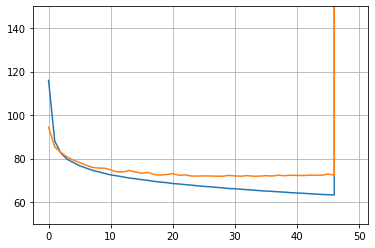

In [28]:
import matplotlib.pyplot as plt
plt.plot(train_loss_arr)
plt.plot(test_loss_arr)
plt.ylim(50,150)
plt.grid()
plt.show()

In [29]:
t_im,t_la = next(iter(test_loader))
t_imc = t_im.cuda()
t_re,t_mu_,t_logvar = model(t_imc)
t_mu2,t_logvar2 = model.encode(t_im.cuda())
t_z = model.reparameterize(t_mu2,t_logvar2)
t_re2 = model.decode(t_z)

In [30]:
len(t_re)

100

In [31]:
#(model.RE(t_re,t_imc)/len(t_re))+model.KLD(t_mu_,t_logvar)
model.RE(t_re,t_imc)/len(t_re)
#model.KLD(t_mu_,t_logvar)

tensor(71.9287, device='cuda:0', grad_fn=<DivBackward0>)

In [32]:
model.KLD(t_mu_,t_logvar)

tensor(43.3105, device='cuda:0', grad_fn=<SubBackward0>)

In [33]:
t_la[0]

tensor(0., dtype=torch.float64)

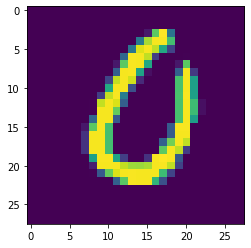

In [34]:
plt.imshow(t_im[0][0][:])

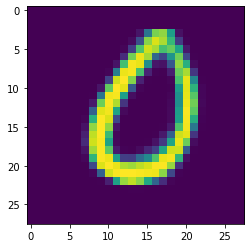

In [35]:
plt.imshow(t_re[0][0][:].detach().cpu().numpy())

# Prediction Test

In [36]:
x_1=[]
y_1=[]

for x , y in iter(test_loader):
    x_1.append(x)
    y_1.append(y)

In [37]:
x_1[0][0].shape

torch.Size([1, 28, 28])

C:\Users\jysin\Anaconda3\envs\jishin\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jysin\Anaconda3\envs\jishin\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


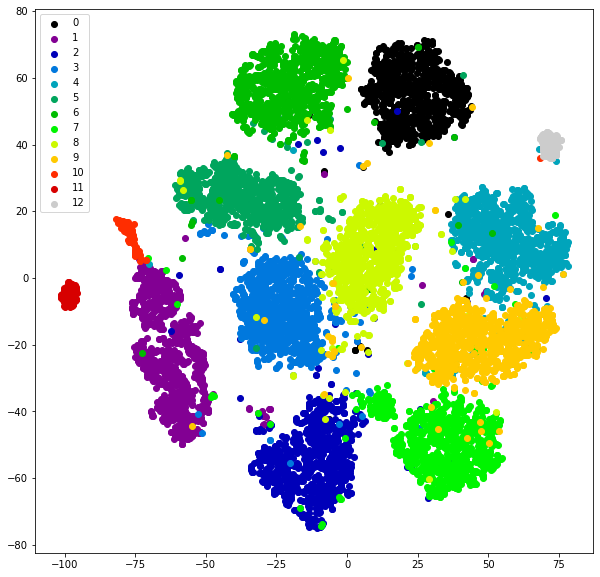

In [38]:
from sklearn.manifold import TSNE
x_t = torch.cat(x_1[:100])
y_t = torch.cat(y_1[:100])
recon,mu,logvar = model(x_t.cuda())
z = model.reparameterize(mu,logvar).detach().cpu().numpy()

tsne = TSNE(n_components=2)
tsneArr = tsne.fit_transform(z)

c_lst = [plt.cm.nipy_spectral(a) for a in np.linspace(0.0, 1.0, len(np.unique(y_t)))]
plt.figure(figsize=(10,10))
for i in range(0,len(np.unique(y_t))):
    plt.scatter(tsneArr[y_t==i,0],tsneArr[y_t==i,1],label=i,color=c_lst[i])
plt.legend(loc='best')

In [39]:
x_1=[]
y_1=[]

for x , y in iter(test_loader):
    x_1.append(x)
    y_1.append(y)

In [40]:
x_2 = torch.cat(x_1[:])
y_2 = torch.cat(y_1[:])

In [41]:
model_prediction = model.predict(x_2[:5000].cuda())

In [42]:
gt = y_2[:5000]

In [43]:
for i in range(0,nClusters):
    print('model prediction for ', i, ' : ',model_prediction[gt==i].reshape(1,len(model_prediction[gt==i])).flatten())

model prediction for  0  :  [ 5  0  0  2  6  3  0  2  2  6  5  9  5 11  7  0  7 11  9  2  0  0 11  9
  9  0  0  5  3  7 11  0  1  5 12  5  0 10  0 12  6  7  0  5  9  5  0  5
  5  0  0  0  2 11  0  0  0  9  5 11  4  9  0  0  0  0  7  1  0  1  1  2
  9  7  0 11  7  0  3  2  5  6  5 11  0  5  2 11  0  9  7  7  7  7  0  7
  9  7  1  2  2 11  0  9  0  9  3  0  1  5  5  6  0  0  2  1 11  2  7  6
  0  0  5  7  3  9  9  5  5  0  0  5  7  0  1  3  7  2 11  1  0  7  9  2
  9  0  1  0 11  7  5  0  3  0  9  6  0  0  5  0  1  0  0  0  4  5  9  5
  1  0  1  2  0 11  5  0  1  0  5  0  0 11  2  0  0  0  6 11  3  1  0  0
  0  5 11  0  0  1  5  4  3  5  5  5  6  1  2  0  6  0  5  0 11  9  9  0
  0  0  5  0  0  5  2  7  5  9  0  9  5  7  1  0  0  5  0  2  0 11  0  2
  5  2  5  9  0  7  2  2  5 11 11  1  5  7  5  9  5  7  0  5  1  0  0  7
  2  0  5  5  1  3  0  1  7  2 11  5 11  0  0  1  4  0  5  7  7  9  4  0
  0  1 11  7  9  0  0  9  0  3  2  6 11  0  0  3  7  7  0  1  1  5  0  9
  7  4  5  4  6  1  0 1

In [44]:
for i in range(0,nClusters):
    uni,count = np.unique(model_prediction[gt==i].reshape(1,len(model_prediction[gt==i])).flatten(),return_counts=True)
    print('GT : ',i,'Model prediction :',uni[np.argmax(count)])

GT :  0 Model prediction : 0
GT :  1 Model prediction : 1
GT :  2 Model prediction : 5
GT :  3 Model prediction : 5
GT :  4 Model prediction : 5
GT :  5 Model prediction : 3
GT :  6 Model prediction : 5
GT :  7 Model prediction : 1
GT :  8 Model prediction : 5
GT :  9 Model prediction : 5
GT :  10 Model prediction : 10
GT :  11 Model prediction : 4
GT :  12 Model prediction : 10


In [53]:
for i in range(0,nClusters):
    uni,count = np.unique(gt[model_prediction.reshape(1,len(np.array(model_prediction)))==i].flatten(),return_counts=True)
    #print(uni, count)
    #plt.plot(uni,count)
    #plt.show()
    print('Most frequent GT in model cluster ',i,' is ',uni[np.argmax(count)])

Most frequent GT in model cluster  0  is  0.0
Most frequent GT in model cluster  1  is  1.0
Most frequent GT in model cluster  2  is  6.0
Most frequent GT in model cluster  3  is  5.0
Most frequent GT in model cluster  4  is  7.0
Most frequent GT in model cluster  5  is  9.0
Most frequent GT in model cluster  6  is  7.0
Most frequent GT in model cluster  7  is  2.0
Most frequent GT in model cluster  8  is  1.0
Most frequent GT in model cluster  9  is  0.0
Most frequent GT in model cluster  10  is  2.0
Most frequent GT in model cluster  11  is  0.0
Most frequent GT in model cluster  12  is  3.0


In [55]:
for i in range(0,nClusters):
    uni,count = np.unique(gt[model_prediction.reshape(1,len(np.array(model_prediction)))==i].flatten(),return_counts=True)
    print(i,':',uni, count)

0 : [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 11. 12.] [134   3  74  35  46  40  77  11  32  28  12   1]
1 : [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [ 39 253  27  68  34  39  23 124 123  28]
2 : [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [35 12  5 69  7  2 83  5 12 50]
3 : [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 12.] [ 21   9  41  18  14 103  15  14  49   6   4]
4 : [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 11.] [ 12   2  28  26  28  51  45 107  54   8  24]
5 : [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 11.] [ 77 110 109  84 221  54 174 119 126 262   3]
6 : [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [15 14 14 58 18 23 49 73 27 54]
7 : [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 12.] [50 41 69 24 33 30  5 28 43 10  5  8]
8 : [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [ 3 61  6 14  5 11  1  4  3  9]
9 : [0. 2. 3. 4. 5. 6. 7. 9.] [41  1  9  7  1  3  1 10]
10 : [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.] [ 1 32 85 11 28  6  5  1  2  9 45  3 51]
11 : [0. 2. 3. 4. 5. 6. 7. 8. 9.] [34 15 30  9 17 11 12  6  4]
12 : [ 0.  1.  

In [58]:
model_prediction[gt==1].shape

(540,)

In [46]:
for i in range(0,nClusters):
    print(i,' : ',gt[gt==i].shape)

0  :  torch.Size([467])
1  :  torch.Size([540])
2  :  torch.Size([490])
3  :  torch.Size([496])
4  :  torch.Size([486])
5  :  torch.Size([394])
6  :  torch.Size([499])
7  :  torch.Size([502])
8  :  torch.Size([478])
9  :  torch.Size([485])
10  :  torch.Size([50])
11  :  torch.Size([49])
12  :  torch.Size([64])
